In [1]:
!export TF_BLAS=libopenblas

In [2]:
import pandas as pd
import numpy as np
import tensorflow
import matplotlib.pyplot as plt
import glob

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Data

In [3]:
# construct dataframe from multiple csv files

# get list of available csv files
csv_files = glob.glob('./data/*.csv')

# read each file and create final df
dataframes = []
for file in csv_files:
    temp_df = pd.read_csv(file)
    dataframes.append(temp_df)

df = pd.concat(dataframes, ignore_index=True)
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')  # convert unix_train time to date time
df.sort_values(by='Timestamp', inplace=True)  # sort by timestamp

# n_feeatures = 3  # number of features used to train

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44979 entries, 38532 to 38531
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Number     44979 non-null  float64       
 1   Timestamp  44979 non-null  datetime64[ns]
 2   IP         44979 non-null  object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.4+ MB


# Feature Eng.

In [5]:
def get_time_attr(row: pd.Series, part: str):
    """Return the specified part of the timestamp.

    Args:
        row (pd.Series): Dataframe row
        part (str): Should be a valid `pandas.Timestamp` attribute

    Returns:
        any: Specified attribute of the timestamp
    """
    return getattr(row, part)

In [6]:
# Get time attributes and add to dataframe
needed_time_attrs = ["hour", "minute"]

for attr in needed_time_attrs:
    df[attr] = df["Timestamp"].apply(lambda x: get_time_attr(x, attr))


# Data preprocessing

In [7]:
# train test split
train_fraction = 0.8
split_point = int(len(df) * train_fraction)

df_train = df.iloc[:split_point]
df_test = df.iloc[split_point:]

In [8]:
# raw sequence data
train_raw_seq = np.array(df_train[["Number", "hour", "minute"]])
n_features = train_raw_seq.shape[-1]  # Number of features being used
n_look_back = 50  # Number of historical data points to learn for each result

In [9]:
# look back sequences
def split_sequence(sequence: np.ndarray, n_steps: int, n_features: int):
    """Make sub sequences of n length and the prediction value and return them

    Args:
        sequence (numpy.ndarray): The sequence of training data
        n_steps (int): How many past data points to look at
        n_features (int): Total number of features in given dataset
    """

    x, y = [], []

    for i in range(len(sequence)):
        # find index of end of current learning slice
        end_i = i + n_steps

        # check if end is beyond the length of sequence
        if end_i > len(sequence) - 1:  # -1 since last element needs to be the prediction value
            break
        else:
            seq_x = sequence[i:end_i]  # training sequence
            seq_y = sequence[end_i]  # prediction value

            x.append(seq_x)
            y.append(seq_y)

    # Reshape data
    x = np.array(x)
    y = np.array(y)

    x = x.reshape(x.shape[0], x.shape[1], n_features)  # each internal array contains data of each timestep
    y = y.reshape(-1, n_features)
    
    return x, y

In [10]:
# Get train, test splits
X_train, y_train = split_sequence(train_raw_seq, n_look_back, n_features)

# Models

In [11]:
# construct model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def train_model(X_train, y_train, n_features, n_look_back, activation_function, epoch_count=15, optimizer_algorithm='adam', loss_metric='mean_squared_logarithmic_error'):
    # define model
    model = Sequential()
    model.add(LSTM(n_look_back, activation=activation_function, input_shape=(n_look_back, n_features)))
    model.add(Dense(1))
    model.compile(optimizer=optimizer_algorithm, loss=loss_metric)

    # fit model
    history = model.fit(X_train, y_train, epochs=epoch_count, verbose=3, validation_split=0.2)

    # plot train and validation loss
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Model loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Train", "Validation"], loc="upper right")
    plt.show()

    # return trained model object
    return model

Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15


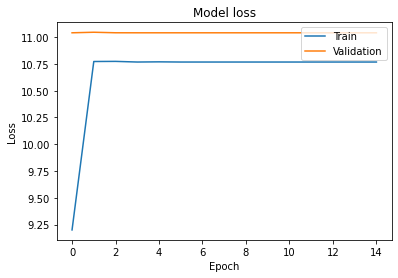

In [12]:
# ReLu
model_1 = train_model(X_train, y_train, n_features, n_look_back, 'relu')

In [13]:
# save model to file
model_1_path = './models/02-hour_min-relu.keras'
model_1.save(model_1_path)

Epoch 1/15
Epoch 2/15
Epoch 3/15
Epoch 4/15
Epoch 5/15
Epoch 6/15
Epoch 7/15
Epoch 8/15
Epoch 9/15
Epoch 10/15
Epoch 11/15
Epoch 12/15
Epoch 13/15
Epoch 14/15
Epoch 15/15


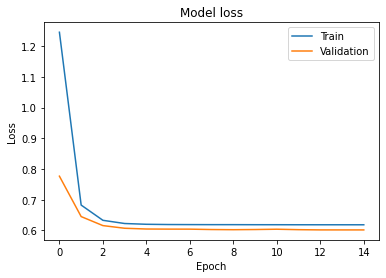

In [14]:
# Sigmoid
model_2 = train_model(X_train, y_train, n_features, n_look_back, 'sigmoid')

In [15]:
# save model to file
model_2_path = './models/02-hour_min-sigmoid.keras'
model_2.save(model_2_path)

# Evaluate

In [16]:
# define evaluate function
def evaluate_msle(model: tensorflow.keras.models.Sequential, preds: np.array, ground_truths: np.array):
    m = tensorflow.keras.metrics.MeanSquaredLogarithmicError()
    m.update_state(ground_truths, preds)
    metric = m.result().numpy()
    m.reset_state()
    return metric

In [22]:
# Load models again
model_1 = tensorflow.keras.models.load_model(model_1_path)
model_2 = tensorflow.keras.models.load_model(model_2_path)

In [24]:
# test data
test_raw_seq = np.array(df_test[["Number", "hour", "minute"]])
X_test, y_test = split_sequence(test_raw_seq, n_look_back, n_features)

In [25]:
# make predictions
preds_1 = model_1.predict(X_test)
preds_2 = model_2.predict(X_test)

280/280 [==============================] - 1s 3ms/step


In [26]:
print("Model 1 MSLE: ", evaluate_msle(model_1, preds_1, y_test))
print("Model 2 MSLE: ", evaluate_msle(model_2, preds_2, y_test))

Model 1 MSLE:  10.388537
Model 2 MSLE:  0.6216314
